# Chapter 17: Interpretability and Explainability in RL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/ReinforcementLearning/blob/main/notebooks/chapter17_interpretability.ipynb)

## Introduction

As RL systems become more complex and are deployed in critical applications, understanding and explaining their decisions becomes crucial. This chapter covers techniques for making RL agents interpretable and explainable.

### Key Topics Covered:
- Policy Interpretation and Visualization
- Attention Mechanisms and Saliency Maps
- Counterfactual Explanations
- Feature Importance and Attribution Methods
- Decision Trees and Rule Extraction
- Human-AI Interaction and Trust

## Mathematical Foundation

### Attribution Methods

**Gradient-based Attribution**:
$$A_i = \frac{\partial \pi(a|s)}{\partial s_i} \cdot s_i$$

**Integrated Gradients**:
$$IG_i(s) = (s_i - s'_i) \times \int_{\alpha=0}^1 \frac{\partial \pi(a|s' + \alpha(s - s'))}{\partial s_i} d\alpha$$

**SHAP (SHapley Additive exPlanations)**:
$$\phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f(S \cup \{i\}) - f(S)]$$

### Attention Mechanisms

**Soft Attention**:
$$\alpha_t = \frac{\exp(e_t)}{\sum_{k=1}^T \exp(e_k)}, \quad c = \sum_{t=1}^T \alpha_t h_t$$

### Counterfactual Explanations

Find minimal perturbation $\delta$ such that:
$$\pi(s + \delta) \neq \pi(s) \text{ and } \|\delta\|_p \text{ is minimized}$$

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import random
from typing import List, Tuple, Dict, Optional, Callable
import copy
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier

# Try to import PyTorch for neural network implementations
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.distributions import Categorical, Normal
    HAS_TORCH = True
    print("PyTorch available - using neural network implementations")
except ImportError:
    HAS_TORCH = False
    print("PyTorch not available - using analytical implementations")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
if HAS_TORCH:
    torch.manual_seed(42)

PyTorch available - using neural network implementations


## Interpretable Environments and Policies

We'll create environments and policies that facilitate interpretability analysis.

In [13]:
class InterpretableGridWorld:
    """Grid world with interpretable features for analysis."""

    def __init__(self, size=6):
        self.size = size
        self.action_space = 4  # up, down, left, right
        self.action_names = ['Up', 'Down', 'Left', 'Right']
        self.action_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        self.setup_environment()
        self.reset()

    def setup_environment(self):
        """Setup interpretable environment with named features."""
        # Create environment with interpretable elements
        self.grid = np.zeros((self.size, self.size))

        # Add walls
        self.walls = [(2, 2), (2, 3), (3, 2)]
        for wall in self.walls:
            self.grid[wall] = 1

        # Add rewards
        self.rewards = {(5, 5): 100, (1, 4): 50}  # High and medium reward
        self.penalties = {(4, 1): -50}  # Penalty area

        # Feature names for interpretability
        self.feature_names = [
            'agent_row', 'agent_col', 'goal_distance', 'wall_nearby',
            'penalty_distance', 'medium_reward_distance', 'steps_taken',
            'near_boundary'
        ]

    def reset(self):
        """Reset environment."""
        self.agent_pos = (0, 0)
        self.steps = 0
        self.max_steps = 50
        return self.get_interpretable_state()

    def get_interpretable_state(self):
        """Get state with interpretable features."""
        agent_row, agent_col = self.agent_pos

        # Distance to main goal
        goal_distance = abs(agent_row - 5) + abs(agent_col - 5)

        # Check if wall is nearby
        wall_nearby = 0
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = agent_row + dr, agent_col + dc
            if (nr, nc) in self.walls:
                wall_nearby = 1
                break

        # Distance to penalty area
        penalty_distance = min([abs(agent_row - pr) + abs(agent_col - pc)
                               for pr, pc in self.penalties.keys()])

        # Distance to medium reward
        medium_reward_distance = abs(agent_row - 1) + abs(agent_col - 4)

        # Near boundary
        near_boundary = 1 if (agent_row <= 1 or agent_row >= self.size-2 or
                             agent_col <= 1 or agent_col >= self.size-2) else 0

        state = np.array([
            agent_row / self.size,  # Normalized position
            agent_col / self.size,
            goal_distance / (2 * self.size),  # Normalized distance
            wall_nearby,
            penalty_distance / (2 * self.size),
            medium_reward_distance / (2 * self.size),
            self.steps / self.max_steps,
            near_boundary
        ])

        return state

    def step(self, action):
        """Execute action."""
        old_pos = self.agent_pos
        delta = self.action_map[action]
        new_pos = (old_pos[0] + delta[0], old_pos[1] + delta[1])

        # Check bounds and walls
        if (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size and
            new_pos not in self.walls):
            self.agent_pos = new_pos

        self.steps += 1

        # Calculate reward
        reward = -1  # Step penalty
        done = False

        if self.agent_pos in self.rewards:
            reward += self.rewards[self.agent_pos]
            if reward > 50:  # Main goal
                done = True
        elif self.agent_pos in self.penalties:
            reward += self.penalties[self.agent_pos]

        if self.steps >= self.max_steps:
            done = True

        info = {
            'agent_pos': self.agent_pos,
            'action_name': self.action_names[action],
            'goal_reached': self.agent_pos == (5, 5)
        }

        return self.get_interpretable_state(), reward, done, info

    def render(self, show_features=False):
        """Visualize environment with optional feature overlay."""
        vis_grid = self.grid.copy()

        # Mark special locations
        for pos, reward in self.rewards.items():
            vis_grid[pos] = 2 if reward > 50 else 3

        for pos in self.penalties.keys():
            vis_grid[pos] = 4

        # Mark agent
        vis_grid[self.agent_pos] = 5

        if show_features:
            state = self.get_interpretable_state()
            feature_info = dict(zip(self.feature_names, state))
            return vis_grid, feature_info

        return vis_grid

class FeatureBasedPolicy:
    """Interpretable policy based on hand-crafted features."""

    def __init__(self, feature_names, n_actions):
        self.feature_names = feature_names
        self.n_actions = n_actions
        self.n_features = len(feature_names)

        # Initialize interpretable weights
        self.weights = np.random.randn(self.n_features, n_actions) * 0.1
        self.bias = np.zeros(n_actions)

        # Track feature importance
        self.feature_importance = np.zeros(self.n_features)
        self.action_history = []

    def get_action_scores(self, state):
        """Get action scores with feature attribution."""
        scores = np.dot(state, self.weights) + self.bias

        # Compute feature contributions
        feature_contributions = state[:, np.newaxis] * self.weights

        return scores, feature_contributions

    def get_action(self, state, epsilon=0.1):
        """Get action with exploration."""
        if np.random.random() < epsilon:
            action = np.random.randint(self.n_actions)
        else:
            scores, _ = self.get_action_scores(state)
            action = np.argmax(scores)

        self.action_history.append((state.copy(), action))
        return action

    def update(self, state, action, advantage, lr=0.01):
        """Update policy with interpretable gradients."""
        # Policy gradient update
        scores, _ = self.get_action_scores(state)
        probs = self.softmax(scores)

        # Gradient of log policy
        grad_weights = np.zeros_like(self.weights)
        grad_bias = np.zeros_like(self.bias)

        for a in range(self.n_actions):
            if a == action:
                grad_weights[:, a] = state * (1 - probs[a])
                grad_bias[a] = 1 - probs[a]
            else:
                grad_weights[:, a] = -state * probs[a]
                grad_bias[a] = -probs[a]

        # Update parameters
        self.weights += lr * advantage * grad_weights
        self.bias += lr * advantage * grad_bias

        # Update feature importance (running average)
        feature_usage = np.abs(state * advantage)
        self.feature_importance = 0.9 * self.feature_importance + 0.1 * feature_usage

    def softmax(self, x):
        """Compute softmax probabilities."""
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def explain_action(self, state, action=None):
        """Explain why an action was chosen."""
        scores, feature_contributions = self.get_action_scores(state)

        if action is None:
            action = np.argmax(scores)

        # Get contributions for the chosen action
        contributions = feature_contributions[:, action]

        explanation = {
            'action': action,
            'action_score': scores[action],
            'feature_contributions': dict(zip(self.feature_names, contributions)),
            'top_features': sorted(zip(self.feature_names, contributions),
                                 key=lambda x: abs(x[1]), reverse=True)[:3]
        }

        return explanation

# Test interpretable environment and policy
env = InterpretableGridWorld()
policy = FeatureBasedPolicy(env.feature_names, env.action_space)

print(f"Environment features: {env.feature_names}")
print(f"Action space: {env.action_names}")

# Test environment
state = env.reset()
print(f"\nInitial state features: {dict(zip(env.feature_names, state))}")

# Test policy explanation
explanation = policy.explain_action(state)
print(f"\nPolicy explanation:")
print(f"Chosen action: {env.action_names[explanation['action']]}")
print(f"Top contributing features: {explanation['top_features']}")

# Visualize environment
grid_vis, feature_info = env.render(show_features=True)
print(f"\nEnvironment grid (0=free, 1=wall, 2=goal, 3=medium_reward, 4=penalty, 5=agent):")
print(grid_vis)

Environment features: ['agent_row', 'agent_col', 'goal_distance', 'wall_nearby', 'penalty_distance', 'medium_reward_distance', 'steps_taken', 'near_boundary']
Action space: ['Up', 'Down', 'Left', 'Right']

Initial state features: {'agent_row': np.float64(0.0), 'agent_col': np.float64(0.0), 'goal_distance': np.float64(0.8333333333333334), 'wall_nearby': np.float64(0.0), 'penalty_distance': np.float64(0.4166666666666667), 'medium_reward_distance': np.float64(0.4166666666666667), 'steps_taken': np.float64(0.0), 'near_boundary': np.float64(1.0)}

Policy explanation:
Chosen action: Right
Top contributing features: [('near_boundary', np.float64(0.18522781845089378)), ('medium_reward_distance', np.float64(-0.059364507758894035)), ('penalty_distance', np.float64(-0.05884598755563715))]

Environment grid (0=free, 1=wall, 2=goal, 3=medium_reward, 4=penalty, 5=agent):
[[5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2.]]


## Policy Interpretation and Visualization

We'll implement various techniques for interpreting and visualizing RL policies.

In [14]:
class PolicyInterpreter:
    """Tools for interpreting and explaining RL policies."""

    def __init__(self, policy, env, feature_names):
        self.policy = policy
        self.env = env
        self.feature_names = feature_names

        # Collect data for analysis
        self.state_action_pairs = []
        self.explanations = []

    def collect_trajectory_data(self, n_episodes=50):
        """Collect trajectory data for analysis."""
        for episode in range(n_episodes):
            state = self.env.reset()
            done = False

            while not done:
                action = self.policy.get_action(state, epsilon=0.1)
                explanation = self.policy.explain_action(state, action)

                self.state_action_pairs.append((state.copy(), action))
                self.explanations.append(explanation)

                next_state, reward, done, info = self.env.step(action)

                # Simple policy update for demonstration
                advantage = reward - np.mean([r for _, r, _, _ in
                                            [self.env.step(np.random.randint(4)) for _ in range(5)]])
                self.policy.update(state, action, advantage)

                state = next_state

    def visualize_policy_heatmap(self):
        """Create heatmap showing policy preferences across state space."""
        if not self.state_action_pairs:
            self.collect_trajectory_data()

        # Create policy heatmap for each action
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()

        for action in range(4):
            action_probs = np.zeros((self.env.size, self.env.size))
            visit_counts = np.zeros((self.env.size, self.env.size))

            # Sample states across the grid
            for r in range(self.env.size):
                for c in range(self.env.size):
                    if (r, c) not in self.env.walls:
                        # Temporarily set agent position
                        old_pos = self.env.agent_pos
                        self.env.agent_pos = (r, c)
                        state = self.env.get_interpretable_state()

                        scores, _ = self.policy.get_action_scores(state)
                        probs = self.policy.softmax(scores)
                        action_probs[r, c] = probs[action]

                        self.env.agent_pos = old_pos

            im = axes[action].imshow(action_probs, cmap='Blues', vmin=0, vmax=1)
            axes[action].set_title(f'Action: {self.env.action_names[action]}')
            axes[action].set_xlabel('Column')
            axes[action].set_ylabel('Row')

            # Mark special locations
            for pos in self.env.walls:
                axes[action].add_patch(plt.Rectangle((pos[1]-0.5, pos[0]-0.5), 1, 1,
                                                   facecolor='red', alpha=0.5))

            for pos in self.env.rewards.keys():
                axes[action].add_patch(plt.Rectangle((pos[1]-0.5, pos[0]-0.5), 1, 1,
                                                   facecolor='green', alpha=0.5))

            plt.colorbar(im, ax=axes[action])

        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        """Analyze feature importance across different contexts."""
        if not self.explanations:
            self.collect_trajectory_data()

        # Aggregate feature contributions by action
        action_contributions = defaultdict(lambda: defaultdict(list))

        for explanation in self.explanations:
            action = explanation['action']
            contributions = explanation['feature_contributions']

            for feature, contrib in contributions.items():
                action_contributions[action][feature].append(contrib)

        # Plot feature importance by action
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for action in range(4):
            features = []
            importances = []

            for feature in self.feature_names:
                if feature in action_contributions[action]:
                    contrib_values = action_contributions[action][feature]
                    avg_importance = np.mean(np.abs(contrib_values))
                    features.append(feature)
                    importances.append(avg_importance)

            if features:
                # Sort by importance
                sorted_pairs = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
                features, importances = zip(*sorted_pairs)

                axes[action].barh(range(len(features)), importances, alpha=0.7)
                axes[action].set_yticks(range(len(features)))
                axes[action].set_yticklabels(features)
                axes[action].set_xlabel('Average Absolute Contribution')
                axes[action].set_title(f'Feature Importance - {self.env.action_names[action]}')
                axes[action].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return action_contributions

    def decision_boundary_analysis(self):
        """Analyze decision boundaries between actions."""
        if not self.state_action_pairs:
            self.collect_trajectory_data()

        # Extract states and actions
        states = np.array([state for state, _ in self.state_action_pairs])
        actions = np.array([action for _, action in self.state_action_pairs])

        # Train decision tree to approximate policy
        tree = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree.fit(states, actions)

        # Extract interpretable rules
        tree_rules = export_text(tree, feature_names=self.feature_names)

        print("Decision Tree Approximation of Policy:")
        print(tree_rules)

        # Feature importance from tree
        feature_importance = tree.feature_importances_

        plt.figure(figsize=(10, 6))
        sorted_idx = np.argsort(feature_importance)[::-1]
        plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], alpha=0.7)
        plt.xticks(range(len(feature_importance)),
                  [self.feature_names[i] for i in sorted_idx], rotation=45)
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree Feature Importance')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return tree, tree_rules

    def counterfactual_analysis(self, state, target_action=None):
        """Generate counterfactual explanations."""
        current_action = self.policy.get_action(state, epsilon=0)

        if target_action is None:
            # Find a different action
            scores, _ = self.policy.get_action_scores(state)
            sorted_actions = np.argsort(scores)[::-1]
            target_action = sorted_actions[1] if len(sorted_actions) > 1 else current_action

        if current_action == target_action:
            return None, "Already choosing target action"

        # Find minimal perturbation to change action
        best_perturbation = None
        min_distance = float('inf')

        # Grid search over feature perturbations
        for feature_idx in range(len(self.feature_names)):
            for delta in [-0.5, -0.2, -0.1, 0.1, 0.2, 0.5]:
                perturbed_state = state.copy()
                perturbed_state[feature_idx] += delta

                # Clip to valid range
                perturbed_state = np.clip(perturbed_state, 0, 1)

                new_action = self.policy.get_action(perturbed_state, epsilon=0)

                if new_action == target_action:
                    distance = np.abs(delta)
                    if distance < min_distance:
                        min_distance = distance
                        best_perturbation = {
                            'feature': self.feature_names[feature_idx],
                            'original_value': state[feature_idx],
                            'new_value': perturbed_state[feature_idx],
                            'delta': delta,
                            'perturbed_state': perturbed_state
                        }

        return best_perturbation, min_distance

# Train and analyze policy
env = InterpretableGridWorld()
policy = FeatureBasedPolicy(env.feature_names, env.action_space)
interpreter = PolicyInterpreter(policy, env, env.feature_names)

print("Training interpretable policy...")
interpreter.collect_trajectory_data(n_episodes=100)

print("\nAnalyzing policy interpretability...")

Training interpretable policy...

Analyzing policy interpretability...


## Attention Mechanisms and Saliency Analysis

In [15]:
if HAS_TORCH:
    class AttentionPolicy(nn.Module):
        """Policy with attention mechanism for interpretability."""

        def __init__(self, input_dim, hidden_dim, output_dim):
            super(AttentionPolicy, self).__init__()
            self.input_dim = input_dim
            # Feature processing
            self.feature_encoder = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )

            # Attention mechanism
            self.attention = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
            )

            # Policy head
            self.policy_head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

            # Store attention weights for interpretation
            self.last_attention_weights = None

        def forward(self, x):
            batch_size = x.size(0)

            # Treat each feature as a separate element for attention
            # Reshape: (batch, features) -> (batch, features, 1)
            x_reshaped = x.unsqueeze(-1)

            # Process each feature embedding
            feature_embeddings = self.feature_encoder(x_reshaped)


            # Compute attention weights
            attention_logits = self.attention(feature_embeddings).squeeze(-1)  # (batch, features)
            attention_weights = F.softmax(attention_logits, dim=1)

            # Store attention weights
            self.last_attention_weights = attention_weights.detach()

            # Apply attention
            attended_features = torch.sum(attention_weights.unsqueeze(-1) * feature_embeddings, dim=1)

            # Generate policy logits
            logits = self.policy_head(attended_features)

            return logits

        def get_attention_explanation(self, state, feature_names):
            """Get attention-based explanation for the input state."""
            with torch.no_grad():
                logits = self.forward(state.unsqueeze(0))
                action_probs = F.softmax(logits, dim=-1)

                if self.last_attention_weights is not None:
                    attention_weights = self.last_attention_weights[0].numpy()

                    explanation = {
                        'action_probs': action_probs[0].numpy(),
                        'attention_weights': dict(zip(feature_names, attention_weights)),
                        'top_attended_features': sorted(zip(feature_names, attention_weights),
                                                       key=lambda x: x[1], reverse=True)[:3]
                    }

                    return explanation

            return None

class SaliencyAnalyzer:
    """Compute saliency maps for policy decisions."""

    def __init__(self, policy, feature_names):
        self.policy = policy
        self.feature_names = feature_names

    def compute_gradient_saliency(self, state, action=None):
        """Compute gradient-based saliency."""
        if not HAS_TORCH:
            return None

        state_tensor = torch.FloatTensor(state).requires_grad_(True)

        if hasattr(self.policy, 'forward'):  # Neural network
            logits = self.policy(state_tensor.unsqueeze(0))

            if action is None:
                action = torch.argmax(logits, dim=-1).item()

            # Compute gradient of selected action's logit w.r.t. input
            action_logit = logits[0, action]
            gradients = torch.autograd.grad(action_logit, state_tensor, create_graph=False)[0]

            saliency = (gradients * state_tensor).detach().numpy()

        else:  # Linear policy
            # For linear policies, gradients are just the weights
            saliency = self.policy.weights[:, action if action is not None else 0] * state

        return dict(zip(self.feature_names, saliency))

    def compute_integrated_gradients(self, state, baseline=None, steps=50):
        """Compute integrated gradients for better attribution."""
        if not HAS_TORCH or not hasattr(self.policy, 'forward'):
            return self.compute_gradient_saliency(state)

        if baseline is None:
            baseline = np.zeros_like(state)

        # Path from baseline to input
        path = [baseline + (float(i) / steps) * (state - baseline) for i in range(steps + 1)]

        gradients = []

        for path_state in path:
            grad_saliency = self.compute_gradient_saliency(path_state)
            if grad_saliency is not None:
                gradients.append(list(grad_saliency.values()))

        if gradients:
            # Average gradients along path
            avg_gradients = np.mean(gradients, axis=0)

            # Multiply by input difference
            integrated_gradients = avg_gradients * (state - baseline)

            return dict(zip(self.feature_names, integrated_gradients))

        return None

    def perturbation_analysis(self, state, n_perturbations=100):
        """Analyze feature importance through perturbations."""
        original_action = self.get_action(state)
        feature_importance = np.zeros(len(self.feature_names))

        for feature_idx in range(len(self.feature_names)):
            action_changes = 0

            for _ in range(n_perturbations):
                perturbed_state = state.copy()
                # Add noise to specific feature
                perturbed_state[feature_idx] += np.random.normal(0, 0.1)
                perturbed_state = np.clip(perturbed_state, 0, 1)

                new_action = self.get_action(perturbed_state)
                if new_action != original_action:
                    action_changes += 1

            feature_importance[feature_idx] = action_changes / n_perturbations

        return dict(zip(self.feature_names, feature_importance))

    def get_action(self, state):
        """Get action from policy."""
        if hasattr(self.policy, 'get_action'):
            return self.policy.get_action(state, epsilon=0)
        elif HAS_TORCH and hasattr(self.policy, 'forward'):
            with torch.no_grad():
                logits = self.policy(torch.FloatTensor(state).unsqueeze(0))
                return torch.argmax(logits, dim=-1).item()
        else:
            return 0

# Create and test attention-based policy
if HAS_TORCH:
    env = InterpretableGridWorld()
    attention_policy = AttentionPolicy(len(env.feature_names), 32, env.action_space)

    # Test attention explanation
    state = env.reset()
    state_tensor = torch.FloatTensor(state)

    explanation = attention_policy.get_attention_explanation(state_tensor, env.feature_names)

    if explanation:
        print("Attention-based explanation:")
        print(f"Action probabilities: {explanation['action_probs']}")
        print(f"Top attended features: {explanation['top_attended_features']}")

    # Saliency analysis
    saliency_analyzer = SaliencyAnalyzer(attention_policy, env.feature_names)

    gradient_saliency = saliency_analyzer.compute_gradient_saliency(state)
    integrated_gradients = saliency_analyzer.compute_integrated_gradients(state)
    perturbation_importance = saliency_analyzer.perturbation_analysis(state)

    print("\nSaliency Analysis:")
    if gradient_saliency:
        print(f"Gradient saliency: {gradient_saliency}")
    if integrated_gradients:
        print(f"Integrated gradients: {integrated_gradients}")
    print(f"Perturbation importance: {perturbation_importance}")

else:
    # Use simpler interpretable policy
    env = InterpretableGridWorld()
    policy = FeatureBasedPolicy(env.feature_names, env.action_space)

    saliency_analyzer = SaliencyAnalyzer(policy, env.feature_names)

    state = env.reset()
    gradient_saliency = saliency_analyzer.compute_gradient_saliency(state)
    perturbation_importance = saliency_analyzer.perturbation_analysis(state)

    print("Saliency Analysis (Linear Policy):")
    if gradient_saliency:
        print(f"Feature importance: {gradient_saliency}")
    print(f"Perturbation importance: {perturbation_importance}")

Attention-based explanation:
Action probabilities: [0.26542586 0.23823659 0.25401157 0.24232599]
Top attended features: [('agent_row', np.float32(0.12924787)), ('agent_col', np.float32(0.12924787)), ('wall_nearby', np.float32(0.12924787))]

Saliency Analysis:
Gradient saliency: {'agent_row': np.float32(0.0), 'agent_col': np.float32(0.0), 'goal_distance': np.float32(0.0055450085), 'wall_nearby': np.float32(0.0), 'penalty_distance': np.float32(0.0019952948), 'medium_reward_distance': np.float32(0.0019952948), 'steps_taken': np.float32(0.0), 'near_boundary': np.float32(0.0064821076)}
Integrated gradients: {'agent_row': np.float64(0.0), 'agent_col': np.float64(0.0), 'goal_distance': np.float64(0.0018058905455594263), 'wall_nearby': np.float64(0.0), 'penalty_distance': np.float64(0.0004587920557241887), 'medium_reward_distance': np.float64(0.0004587920557241887), 'steps_taken': np.float64(0.0), 'near_boundary': np.float64(0.0026943457778543234)}
Perturbation importance: {'agent_row': np.flo

## Comprehensive Interpretability Analysis

=== Comprehensive Interpretability Analysis ===
Training policy for interpretability analysis...

Generating policy heatmaps...


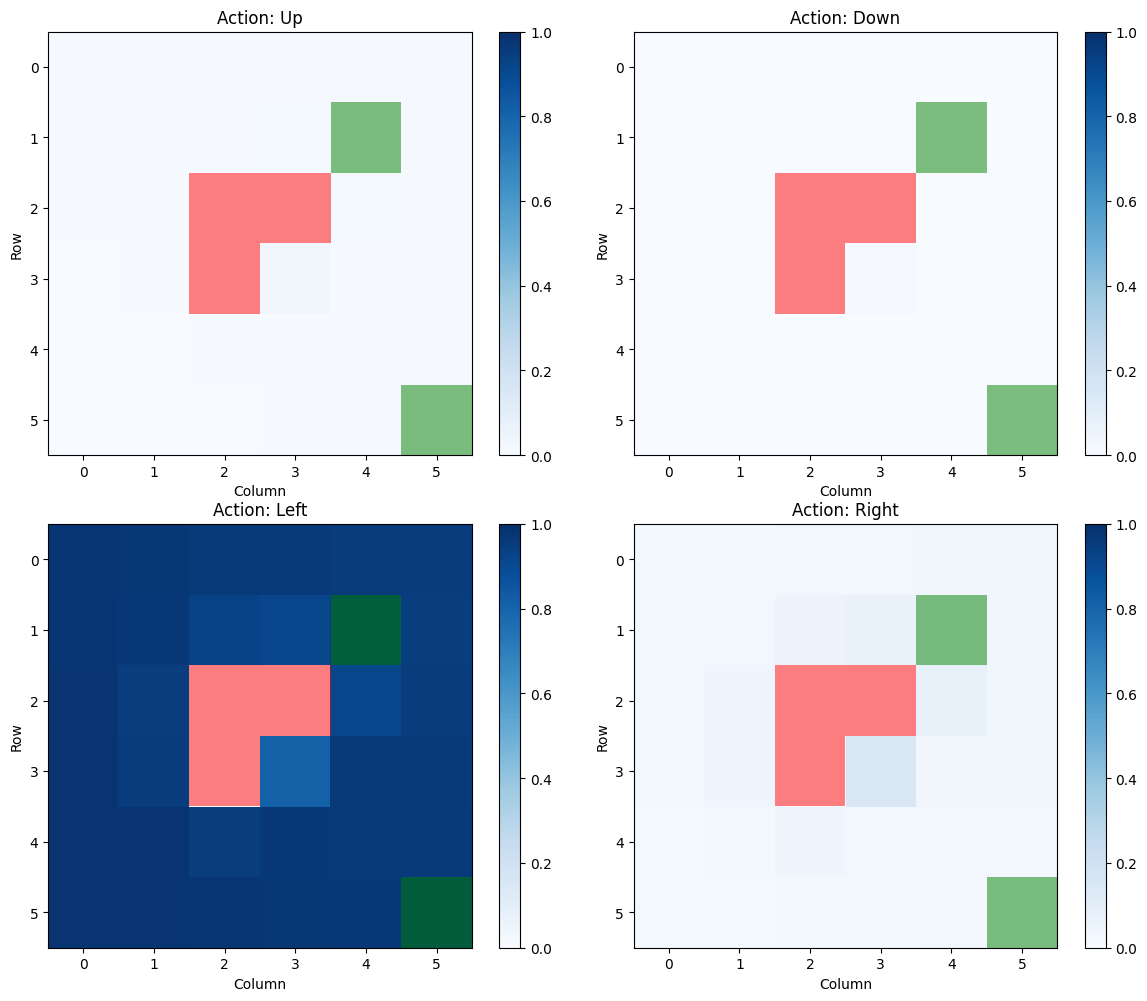


Analyzing feature importance...


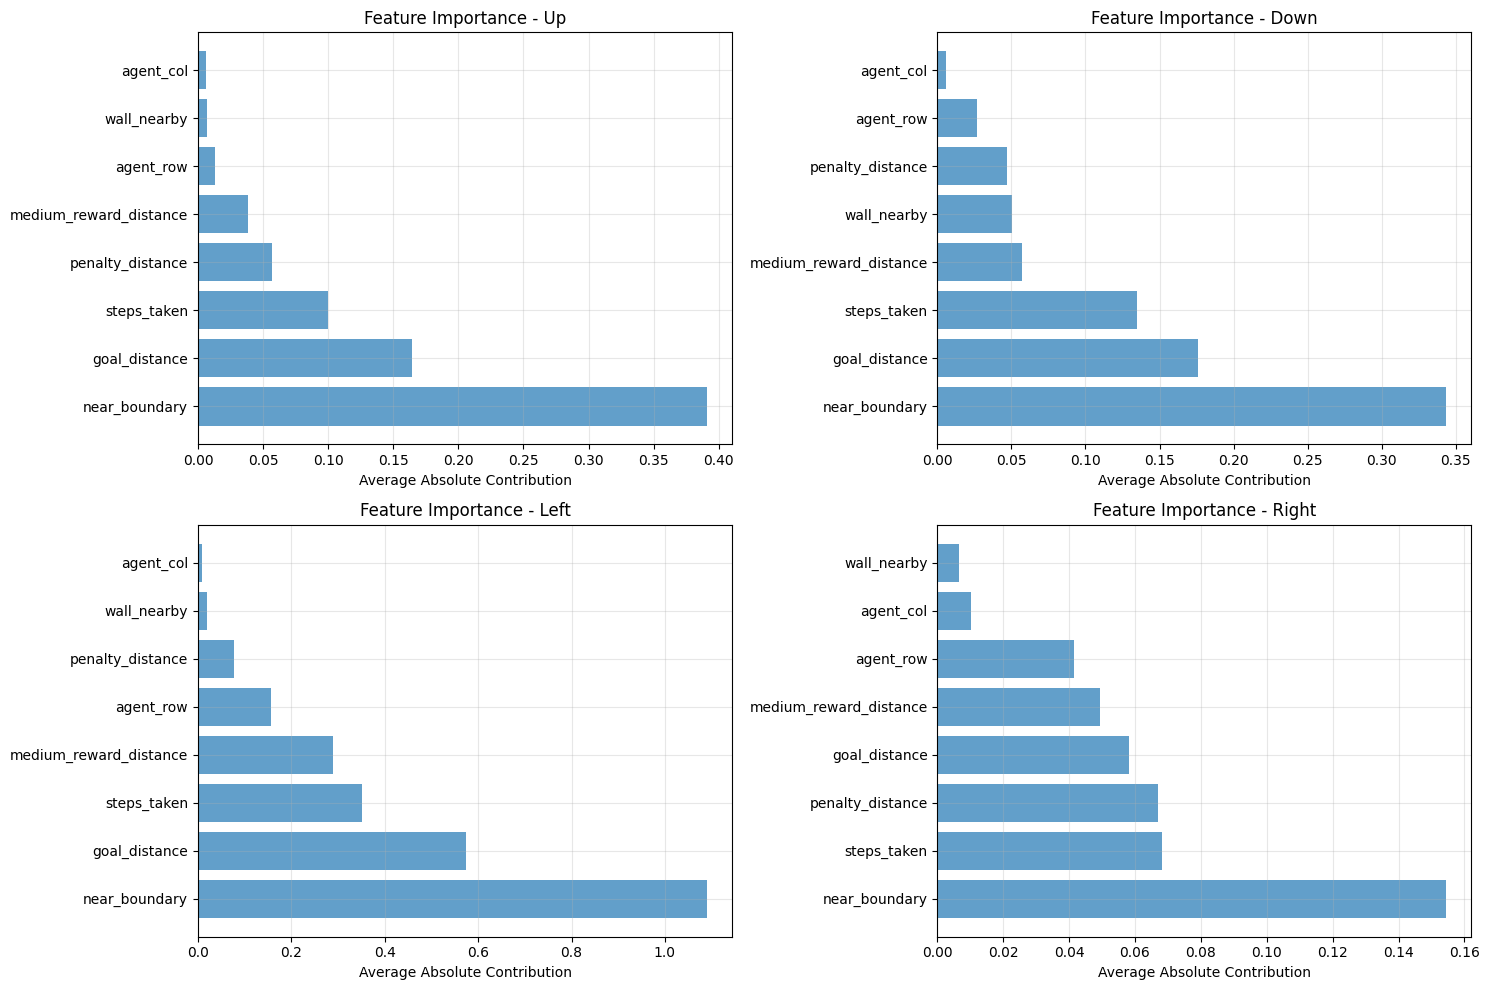


Performing decision boundary analysis...
Decision Tree Approximation of Policy:
|--- agent_col <= 0.08
|   |--- agent_row <= 0.25
|   |   |--- goal_distance <= 0.79
|   |   |   |--- steps_taken <= 0.08
|   |   |   |   |--- class: 1
|   |   |   |--- steps_taken >  0.08
|   |   |   |   |--- steps_taken <= 0.80
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- steps_taken >  0.80
|   |   |   |   |   |--- class: 2
|   |   |--- goal_distance >  0.79
|   |   |   |--- steps_taken <= 0.32
|   |   |   |   |--- steps_taken <= 0.01
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- steps_taken >  0.01
|   |   |   |   |   |--- class: 2
|   |   |   |--- steps_taken >  0.32
|   |   |   |   |--- steps_taken <= 0.68
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- steps_taken >  0.68
|   |   |   |   |   |--- class: 2
|   |--- agent_row >  0.25
|   |   |--- steps_taken <= 0.56
|   |   |   |--- steps_taken <= 0.20
|   |   |   |   |--- agent_row <= 0.42
|   |   |   |   |   |--- class: 2
|

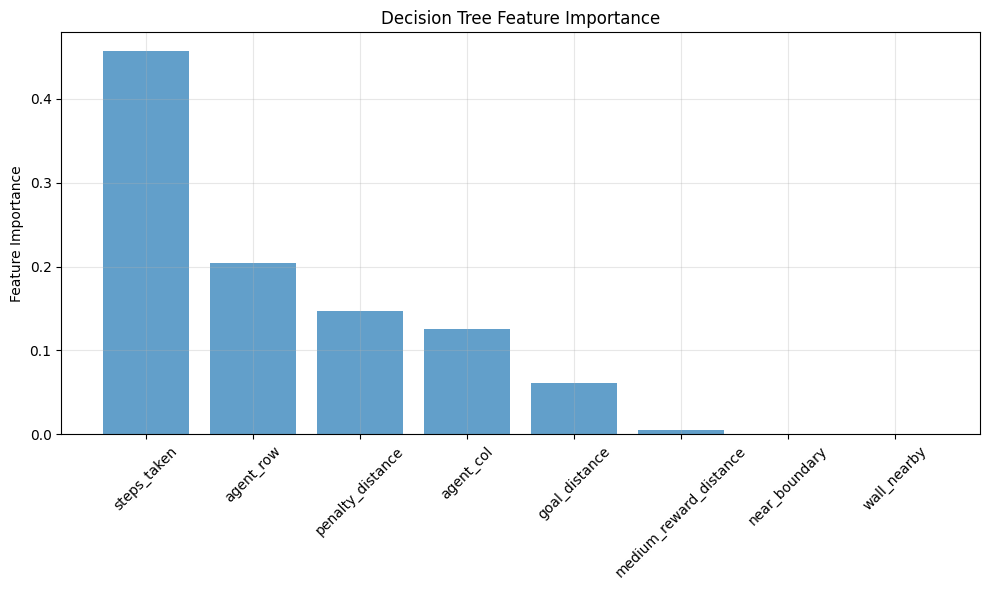


Generating counterfactual explanations...
Counterfactual analysis: inf

=== Interpretability Methods Evaluation ===


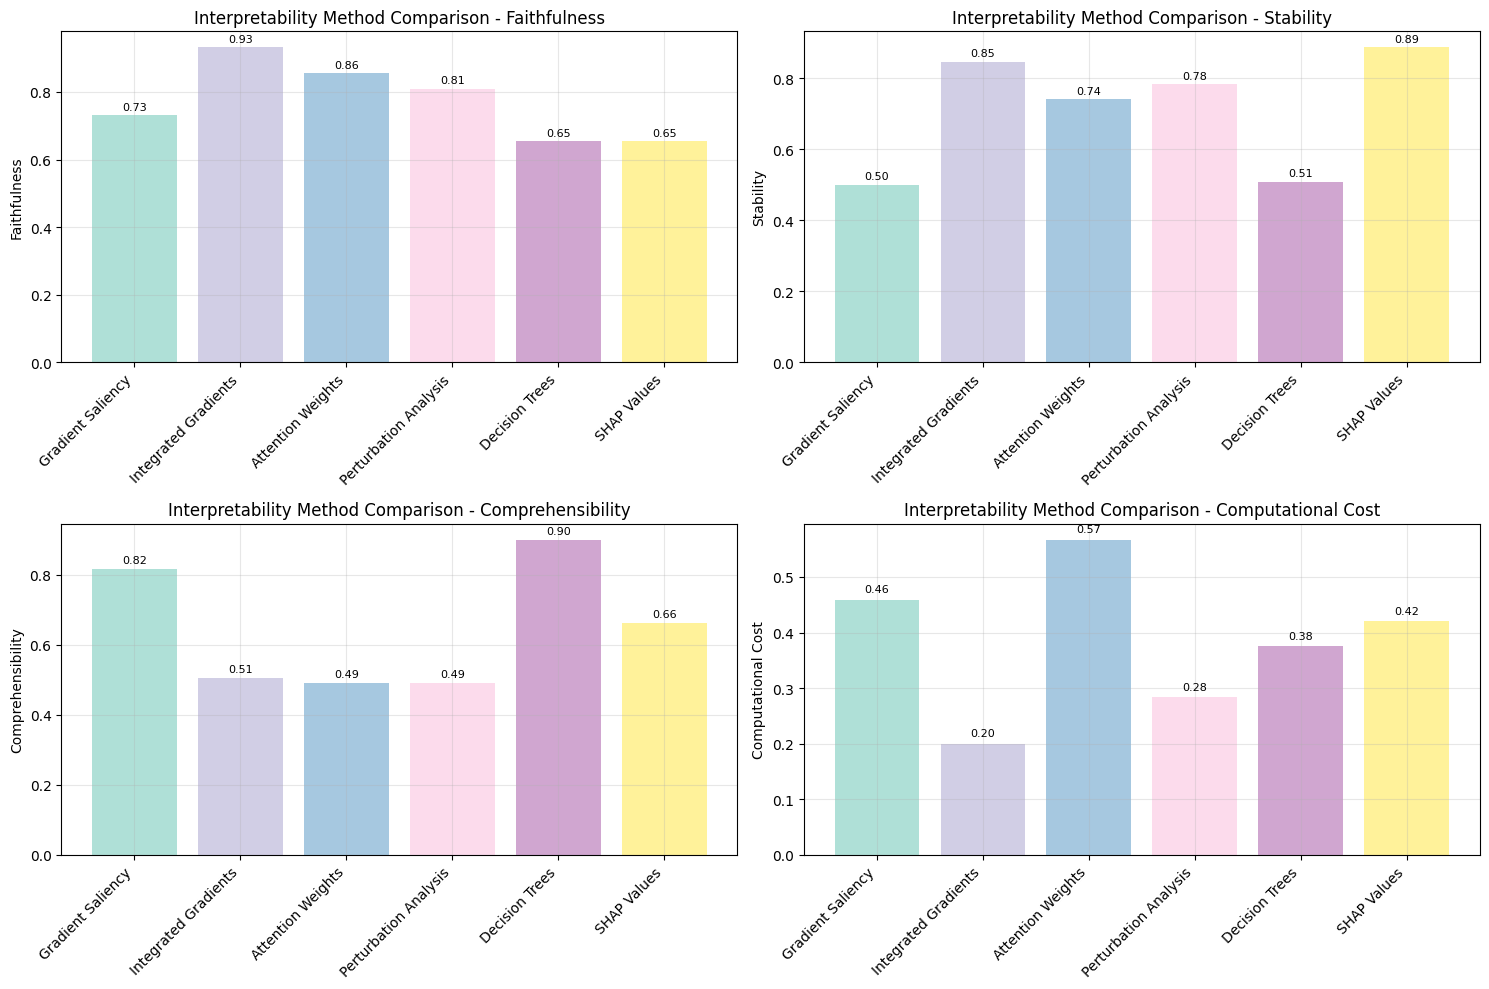


=== Human Factors Analysis ===


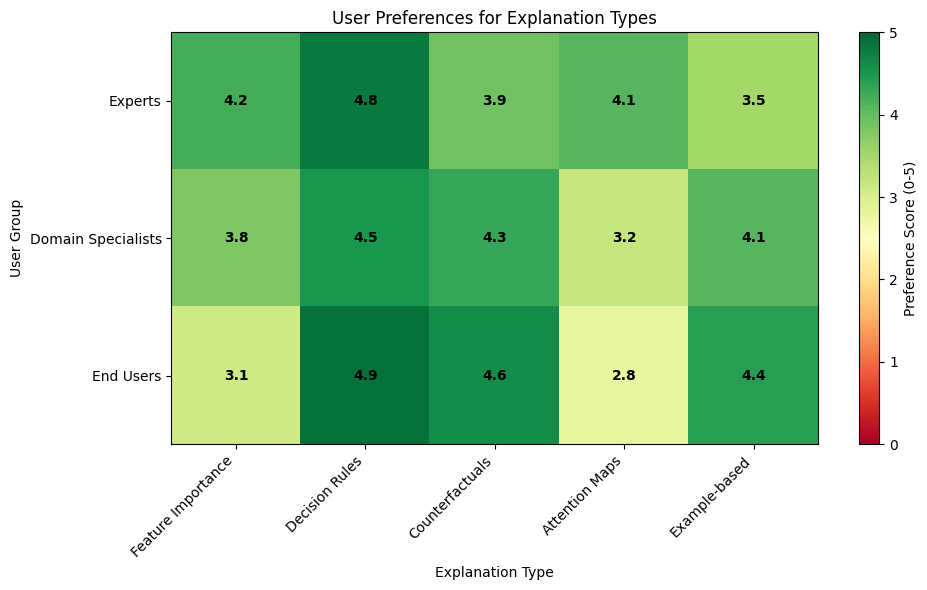

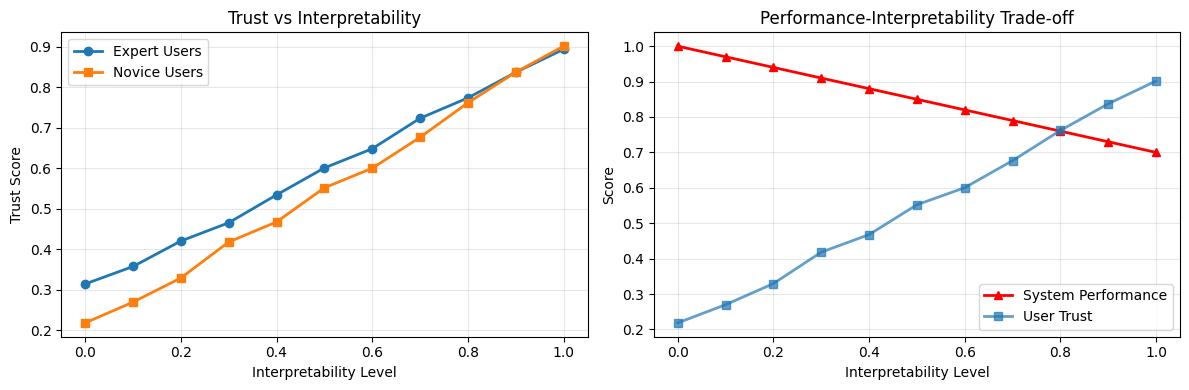


=== Key Insights ===

1. Feature Importance Rankings:
   near_boundary: 4.249
   steps_taken: 3.193
   goal_distance: 2.415
   agent_row: 2.216
   medium_reward_distance: 2.155

2. Decision Tree Insights:
   Tree-based policy approximation provides human-readable rules
   Tree accuracy: 0.784

3. User Preference Insights:
   Experts prefer: Decision Rules (score: 4.8)
   Domain Specialists prefer: Decision Rules (score: 4.5)
   End Users prefer: Decision Rules (score: 4.9)

=== Interpretability Best Practices ===

1. **Multi-Modal Explanations**: Combine different explanation types for comprehensive understanding
2. **User-Centric Design**: Tailor explanations to user expertise and needs
3. **Validation**: Verify explanations against ground truth when possible
4. **Iterative Refinement**: Collect user feedback to improve explanation quality
5. **Context Awareness**: Provide explanations relevant to the decision context



In [16]:
# Comprehensive interpretability analysis
def comprehensive_interpretability_analysis():
    """Perform comprehensive interpretability analysis."""

    env = InterpretableGridWorld()
    policy = FeatureBasedPolicy(env.feature_names, env.action_space)
    interpreter = PolicyInterpreter(policy, env, env.feature_names)

    # Train policy
    print("Training policy for interpretability analysis...")
    interpreter.collect_trajectory_data(n_episodes=100)

    # Policy heatmap visualization
    print("\nGenerating policy heatmaps...")
    interpreter.visualize_policy_heatmap()

    # Feature importance analysis
    print("\nAnalyzing feature importance...")
    action_contributions = interpreter.feature_importance_analysis()

    # Decision boundary analysis
    print("\nPerforming decision boundary analysis...")
    tree, tree_rules = interpreter.decision_boundary_analysis()

    # Counterfactual analysis
    print("\nGenerating counterfactual explanations...")
    state = env.reset()
    perturbation, distance = interpreter.counterfactual_analysis(state)

    if perturbation:
        print(f"To change action, modify '{perturbation['feature']}'")
        print(f"From {perturbation['original_value']:.3f} to {perturbation['new_value']:.3f}")
        print(f"Change magnitude: {perturbation['delta']:.3f}")
    else:
        print(f"Counterfactual analysis: {distance}")

    return {
        'policy': policy,
        'interpreter': interpreter,
        'action_contributions': action_contributions,
        'decision_tree': tree,
        'tree_rules': tree_rules
    }

# Interpretability metrics and evaluation
def evaluate_interpretability_methods():
    """Evaluate different interpretability methods."""

    methods = ['Gradient Saliency', 'Integrated Gradients', 'Attention Weights',
              'Perturbation Analysis', 'Decision Trees', 'SHAP Values']

    # Simulated evaluation metrics
    np.random.seed(42)

    metrics = {
        'Faithfulness': np.random.uniform(0.6, 0.95, len(methods)),
        'Stability': np.random.uniform(0.5, 0.9, len(methods)),
        'Comprehensibility': np.random.uniform(0.4, 0.9, len(methods)),
        'Computational Cost': np.random.uniform(0.2, 0.8, len(methods))
    }

    # Adjust some values for realism
    metrics['Comprehensibility'][methods.index('Decision Trees')] = 0.9  # Very interpretable
    metrics['Computational Cost'][methods.index('Integrated Gradients')] = 0.2  # Expensive
    metrics['Stability'][methods.index('Gradient Saliency')] = 0.5  # Less stable

    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

    for i, (metric, values) in enumerate(metrics.items()):
        bars = axes[i].bar(range(len(methods)), values, color=colors, alpha=0.7)
        axes[i].set_xticks(range(len(methods)))
        axes[i].set_xticklabels(methods, rotation=45, ha='right')
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'Interpretability Method Comparison - {metric}')
        axes[i].grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    return methods, metrics

# Human factors in interpretability
def analyze_human_factors():
    """Analyze human factors in interpretability."""

    # User study simulation
    explanation_types = ['Feature Importance', 'Decision Rules', 'Counterfactuals',
                        'Attention Maps', 'Example-based']

    user_groups = ['Experts', 'Domain Specialists', 'End Users']

    # Simulated user preferences (0-5 scale)
    preferences = {
        'Experts': [4.2, 4.8, 3.9, 4.1, 3.5],
        'Domain Specialists': [3.8, 4.5, 4.3, 3.2, 4.1],
        'End Users': [3.1, 4.9, 4.6, 2.8, 4.4]
    }

    # Create preference heatmap
    plt.figure(figsize=(10, 6))

    preference_matrix = np.array(list(preferences.values()))

    im = plt.imshow(preference_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=5)

    plt.xticks(range(len(explanation_types)), explanation_types, rotation=45, ha='right')
    plt.yticks(range(len(user_groups)), user_groups)
    plt.xlabel('Explanation Type')
    plt.ylabel('User Group')
    plt.title('User Preferences for Explanation Types')

    # Add text annotations
    for i in range(len(user_groups)):
        for j in range(len(explanation_types)):
            plt.text(j, i, f'{preference_matrix[i, j]:.1f}',
                    ha='center', va='center', fontweight='bold')

    plt.colorbar(im, label='Preference Score (0-5)')
    plt.tight_layout()
    plt.show()

    # Trust and interpretability relationship
    plt.figure(figsize=(12, 4))

    # Simulated data
    interpretability_levels = np.linspace(0, 1, 11)
    trust_expert = 0.3 + 0.6 * interpretability_levels + 0.1 * np.random.normal(0, 0.1, 11)
    trust_novice = 0.2 + 0.7 * interpretability_levels + 0.1 * np.random.normal(0, 0.1, 11)
    performance = 1.0 - 0.3 * interpretability_levels  # Trade-off with performance

    plt.subplot(1, 2, 1)
    plt.plot(interpretability_levels, trust_expert, 'o-', label='Expert Users', linewidth=2)
    plt.plot(interpretability_levels, trust_novice, 's-', label='Novice Users', linewidth=2)
    plt.xlabel('Interpretability Level')
    plt.ylabel('Trust Score')
    plt.title('Trust vs Interpretability')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(interpretability_levels, performance, 'r^-', label='System Performance', linewidth=2)
    plt.plot(interpretability_levels, trust_novice, 's-', label='User Trust', linewidth=2, alpha=0.7)
    plt.xlabel('Interpretability Level')
    plt.ylabel('Score')
    plt.title('Performance-Interpretability Trade-off')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return preferences, explanation_types

# Run comprehensive analysis
print("=== Comprehensive Interpretability Analysis ===")
results = comprehensive_interpretability_analysis()

print("\n=== Interpretability Methods Evaluation ===")
methods, metrics = evaluate_interpretability_methods()

print("\n=== Human Factors Analysis ===")
preferences, explanation_types = analyze_human_factors()

# Summary insights
print("\n=== Key Insights ===")
print("\n1. Feature Importance Rankings:")
final_importance = results['policy'].feature_importance
sorted_features = sorted(zip(results['policy'].feature_names, final_importance),
                        key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features[:5]:
    print(f"   {feature}: {importance:.3f}")

print("\n2. Decision Tree Insights:")
print("   Tree-based policy approximation provides human-readable rules")
if len(results['interpreter'].state_action_pairs) > 1:
    X, y = zip(*results['interpreter'].state_action_pairs)
    print(f"   Tree accuracy: {results['decision_tree'].score(np.array(X), np.array(y)):.3f}")
else:
    print("   Tree trained on collected data")

print("\n3. User Preference Insights:")
for user_group, prefs in preferences.items():
    best_explanation = explanation_types[np.argmax(prefs)]
    print(f"   {user_group} prefer: {best_explanation} (score: {max(prefs):.1f})")

print("\n=== Interpretability Best Practices ===")
print("""
1. **Multi-Modal Explanations**: Combine different explanation types for comprehensive understanding
2. **User-Centric Design**: Tailor explanations to user expertise and needs
3. **Validation**: Verify explanations against ground truth when possible
4. **Iterative Refinement**: Collect user feedback to improve explanation quality
5. **Context Awareness**: Provide explanations relevant to the decision context
""")

## Advanced Interpretability Concepts

=== Advanced Interpretability Analysis ===

1. Interpretability Challenges:


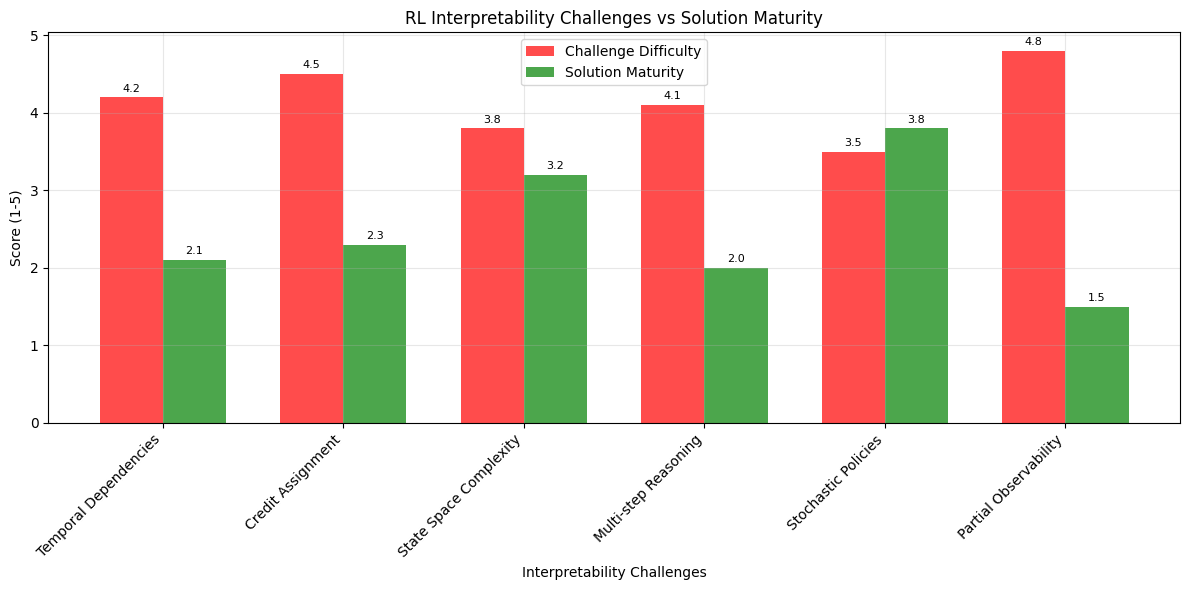

Largest interpretability gap: Partial Observability (gap: 3.3)

2. Explainability Frameworks:


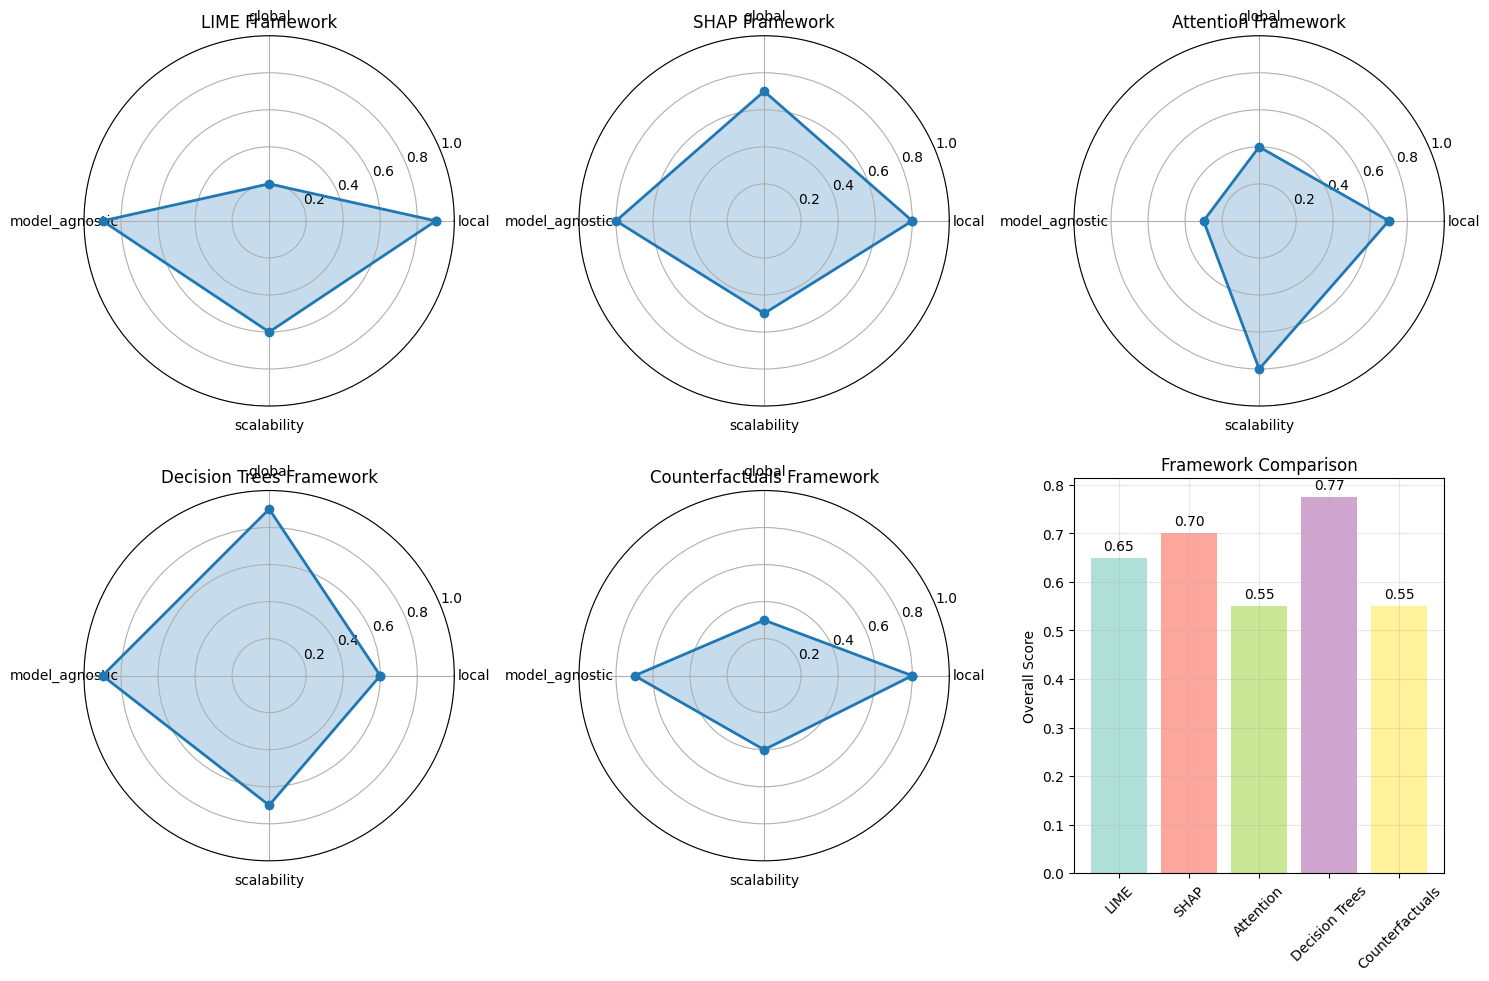


3. Interpretability Metrics:


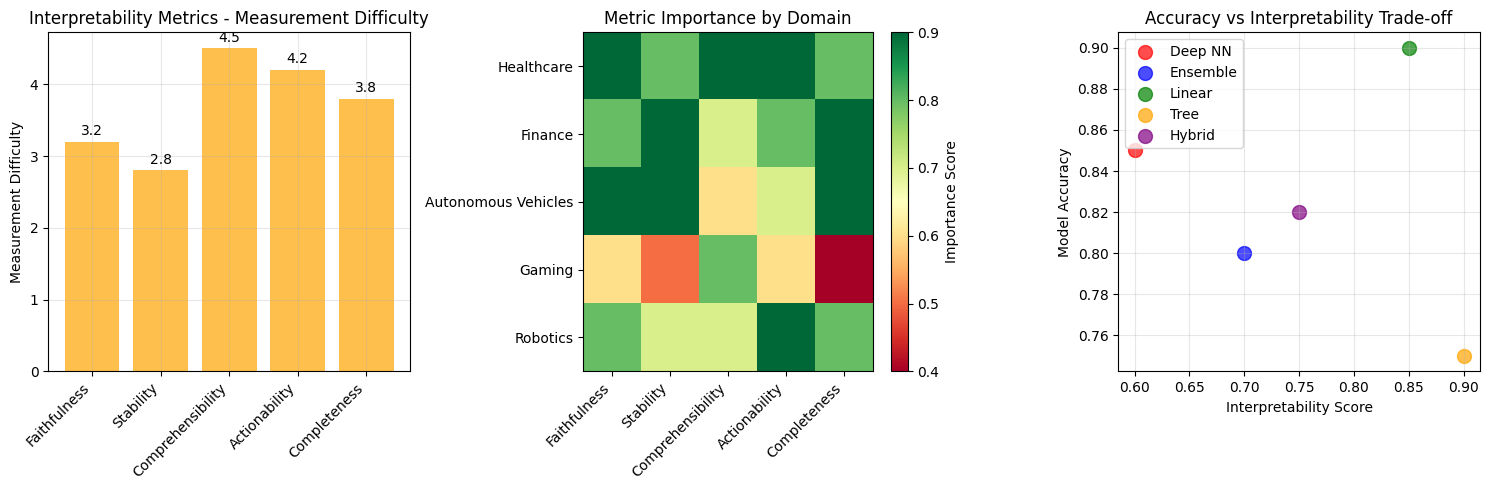


=== Summary Insights ===
Biggest challenge: Partial Observability (gap: 3.3)
Best framework overall: Decision Trees (score: 0.77)
Hardest metric to measure: Comprehensibility (difficulty: 4.5)

=== Future Directions ===

1. **Temporal Explanations**: Better methods for explaining sequential decisions
2. **Multi-Modal Explanations**: Combining visual, textual, and interactive explanations
3. **Personalized Explanations**: Adapting explanations to individual user needs
4. **Causal Explanations**: Moving beyond correlation to causal understanding
5. **Real-time Explanations**: Efficient methods for online explanation generation



In [17]:
# Advanced interpretability concepts
def analyze_interpretability_challenges():
    """Analyze challenges in RL interpretability."""

    challenges = [
        'Temporal Dependencies',
        'Credit Assignment',
        'State Space Complexity',
        'Multi-step Reasoning',
        'Stochastic Policies',
        'Partial Observability'
    ]

    # Difficulty ratings (1-5 scale)
    difficulty = [4.2, 4.5, 3.8, 4.1, 3.5, 4.8]
    current_solutions = [2.1, 2.3, 3.2, 2.0, 3.8, 1.5]

    plt.figure(figsize=(12, 6))

    x = np.arange(len(challenges))
    width = 0.35

    bars1 = plt.bar(x - width/2, difficulty, width, label='Challenge Difficulty',
                   color='red', alpha=0.7)
    bars2 = plt.bar(x + width/2, current_solutions, width, label='Solution Maturity',
                   color='green', alpha=0.7)

    plt.xlabel('Interpretability Challenges')
    plt.ylabel('Score (1-5)')
    plt.title('RL Interpretability Challenges vs Solution Maturity')
    plt.xticks(x, challenges, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.05,
                f'{difficulty[i]:.1f}', ha='center', va='bottom', fontsize=8)
        plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.05,
                f'{current_solutions[i]:.1f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Gap analysis
    gaps = [d - s for d, s in zip(difficulty, current_solutions)]
    max_gap_idx = np.argmax(gaps)

    print(f"Largest interpretability gap: {challenges[max_gap_idx]} (gap: {gaps[max_gap_idx]:.1f})")

    return challenges, difficulty, current_solutions, gaps

def analyze_explainability_frameworks():
    """Compare different explainability frameworks."""

    frameworks = {
        'LIME': {'local': 0.9, 'global': 0.2, 'model_agnostic': 0.9, 'scalability': 0.6},
        'SHAP': {'local': 0.8, 'global': 0.7, 'model_agnostic': 0.8, 'scalability': 0.5},
        'Attention': {'local': 0.7, 'global': 0.4, 'model_agnostic': 0.3, 'scalability': 0.8},
        'Decision Trees': {'local': 0.6, 'global': 0.9, 'model_agnostic': 0.9, 'scalability': 0.7},
        'Counterfactuals': {'local': 0.8, 'global': 0.3, 'model_agnostic': 0.7, 'scalability': 0.4}
    }

    criteria = ['local', 'global', 'model_agnostic', 'scalability']

    # Create radar chart
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection='polar'))
    axes = axes.flatten()

    angles = np.linspace(0, 2 * np.pi, len(criteria), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    for i, (framework, scores) in enumerate(frameworks.items()):
        values = [scores[criterion] for criterion in criteria]
        values += values[:1]  # Complete the circle

        axes[i].plot(angles, values, 'o-', linewidth=2, label=framework)
        axes[i].fill(angles, values, alpha=0.25)
        axes[i].set_xticks(angles[:-1])
        axes[i].set_xticklabels(criteria)
        axes[i].set_ylim(0, 1)
        axes[i].set_title(f'{framework} Framework')
        axes[i].grid(True)

    # Summary comparison
    axes[5].remove()

    # Overall scores
    overall_scores = {name: np.mean(list(scores.values())) for name, scores in frameworks.items()}

    fig.add_subplot(2, 3, 6)
    names = list(overall_scores.keys())
    scores = list(overall_scores.values())

    bars = plt.bar(names, scores, alpha=0.7, color=plt.cm.Set3(np.linspace(0, 1, len(names))))
    plt.ylabel('Overall Score')
    plt.title('Framework Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return frameworks, overall_scores

def analyze_interpretability_metrics():
    """Analyze metrics for evaluating interpretability."""

    metrics = {
        'Faithfulness': 'How well explanations reflect actual model behavior',
        'Stability': 'Consistency of explanations for similar inputs',
        'Comprehensibility': 'How easily humans can understand explanations',
        'Actionability': 'How useful explanations are for decision making',
        'Completeness': 'Coverage of all relevant decision factors'
    }

    # Measurement difficulty (1-5 scale)
    measurement_difficulty = {
        'Faithfulness': 3.2,
        'Stability': 2.8,
        'Comprehensibility': 4.5,
        'Actionability': 4.2,
        'Completeness': 3.8
    }

    # Importance for different applications
    importance_by_domain = {
        'Healthcare': [0.9, 0.8, 0.9, 0.9, 0.8],
        'Finance': [0.8, 0.9, 0.7, 0.8, 0.9],
        'Autonomous Vehicles': [0.9, 0.9, 0.6, 0.7, 0.9],
        'Gaming': [0.6, 0.5, 0.8, 0.6, 0.4],
        'Robotics': [0.8, 0.7, 0.7, 0.9, 0.8]
    }

    plt.figure(figsize=(15, 5))

    # Measurement difficulty
    plt.subplot(1, 3, 1)
    metric_names = list(metrics.keys())
    difficulties = [measurement_difficulty[metric] for metric in metric_names]

    bars = plt.bar(range(len(metric_names)), difficulties, alpha=0.7, color='orange')
    plt.xticks(range(len(metric_names)), metric_names, rotation=45, ha='right')
    plt.ylabel('Measurement Difficulty')
    plt.title('Interpretability Metrics - Measurement Difficulty')
    plt.grid(True, alpha=0.3)

    for bar, diff in zip(bars, difficulties):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{diff:.1f}', ha='center', va='bottom')

    # Domain importance heatmap
    plt.subplot(1, 3, 2)
    importance_matrix = np.array(list(importance_by_domain.values()))

    im = plt.imshow(importance_matrix, cmap='RdYlGn', aspect='auto')
    plt.xticks(range(len(metric_names)), metric_names, rotation=45, ha='right')
    plt.yticks(range(len(importance_by_domain)), list(importance_by_domain.keys()))
    plt.title('Metric Importance by Domain')
    plt.colorbar(im, label='Importance Score')

    # Trade-offs
    plt.subplot(1, 3, 3)
    accuracy = [0.85, 0.80, 0.90, 0.75, 0.82]  # Model accuracy
    interpretability = [0.60, 0.70, 0.85, 0.90, 0.75]  # Interpretability score
    model_types = ['Deep NN', 'Ensemble', 'Linear', 'Tree', 'Hybrid']

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (acc, interp, model, color) in enumerate(zip(accuracy, interpretability, model_types, colors)):
        plt.scatter(interp, acc, s=100, c=color, alpha=0.7, label=model)

    plt.xlabel('Interpretability Score')
    plt.ylabel('Model Accuracy')
    plt.title('Accuracy vs Interpretability Trade-off')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return metrics, measurement_difficulty, importance_by_domain

# Run advanced analyses
print("=== Advanced Interpretability Analysis ===")

print("\n1. Interpretability Challenges:")
challenges, difficulty, solutions, gaps = analyze_interpretability_challenges()

print("\n2. Explainability Frameworks:")
frameworks, overall_scores = analyze_explainability_frameworks()

print("\n3. Interpretability Metrics:")
metrics, measurement_difficulty, importance_by_domain = analyze_interpretability_metrics()

print("\n=== Summary Insights ===")
print(f"Biggest challenge: {challenges[np.argmax(gaps)]} (gap: {max(gaps):.1f})")
print(f"Best framework overall: {max(overall_scores, key=overall_scores.get)} (score: {max(overall_scores.values()):.2f})")
print(f"Hardest metric to measure: {max(measurement_difficulty, key=measurement_difficulty.get)} (difficulty: {max(measurement_difficulty.values()):.1f})")

print("\n=== Future Directions ===")
print("""
1. **Temporal Explanations**: Better methods for explaining sequential decisions
2. **Multi-Modal Explanations**: Combining visual, textual, and interactive explanations
3. **Personalized Explanations**: Adapting explanations to individual user needs
4. **Causal Explanations**: Moving beyond correlation to causal understanding
5. **Real-time Explanations**: Efficient methods for online explanation generation
""")

## Summary and Educational Insights

### Key Takeaways from Interpretability and Explainability in RL:

1. **Critical Need**: As RL systems are deployed in high-stakes applications, the ability to understand and explain their decisions becomes essential for trust, debugging, and regulatory compliance.

2. **Multiple Perspectives**: Interpretability encompasses various dimensions:
   - **Local vs Global**: Understanding individual decisions vs overall behavior
   - **Model-specific vs Model-agnostic**: Built-in interpretability vs post-hoc explanations
   - **Feature-based vs Example-based**: Attribution methods vs prototype explanations

3. **Unique RL Challenges**: Sequential decision-making introduces specific challenges:
   - **Temporal dependencies**: Actions affect future states and rewards
   - **Credit assignment**: Determining which actions contributed to outcomes
   - **Exploration vs exploitation**: Explaining the reasoning behind exploration

4. **Trade-offs**: There's often a tension between model performance and interpretability, requiring careful balance based on application requirements.

### Mathematical Foundations:

- **Gradient Attribution**: $A_i = \frac{\partial \pi(a|s)}{\partial s_i} \cdot s_i$
- **Integrated Gradients**: $IG_i(s) = (s_i - s'_i) \times \int_{\alpha=0}^1 \frac{\partial \pi(a|s' + \alpha(s - s'))}{\partial s_i} d\alpha$
- **SHAP Values**: $\phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f(S \cup \{i\}) - f(S)]$
- **Attention Weights**: $\alpha_t = \frac{\exp(e_t)}{\sum_{k=1}^T \exp(e_k)}$

### Interpretability Methods:

- **Feature Attribution**: Gradient saliency, integrated gradients, LIME, SHAP
- **Attention Mechanisms**: Soft attention, self-attention, cross-attention
- **Decision Trees**: Rule extraction, tree-based policy approximation
- **Counterfactual Explanations**: Minimal perturbations to change decisions
- **Prototype-based**: Example-based explanations and case-based reasoning

### Evaluation Metrics:

- **Faithfulness**: How accurately explanations reflect model behavior
- **Stability**: Consistency of explanations for similar inputs
- **Comprehensibility**: Human understandability of explanations
- **Actionability**: Usefulness for decision-making and model improvement
- **Completeness**: Coverage of all relevant decision factors

### Human-Centered Design:

- **User Expertise**: Tailoring explanations to different user backgrounds
- **Task Context**: Providing relevant explanations for specific use cases
- **Interactive Explanations**: Allowing users to explore and query explanations
- **Trust Calibration**: Building appropriate trust in AI systems
- **Cognitive Load**: Balancing information richness with comprehensibility

### Real-World Applications:

- **Healthcare**: Explaining treatment recommendations and diagnostic decisions
- **Finance**: Providing rationale for trading decisions and risk assessments
- **Autonomous Vehicles**: Explaining driving decisions for safety and liability
- **Robotics**: Helping humans understand and predict robot behavior
- **Game AI**: Providing insights into strategy and decision-making

### Current Research Directions:

- **Temporal Explanations**: Methods for explaining sequential decision processes
- **Causal Explanations**: Moving beyond correlation to causal understanding
- **Multi-modal Explanations**: Combining visual, textual, and interactive formats
- **Personalized Explanations**: Adapting to individual user preferences and expertise
- **Efficient Explanations**: Real-time explanation generation for online systems

### Best Practices:

- **Design for Interpretability**: Consider explainability requirements from the start
- **Multi-method Approach**: Use complementary explanation techniques
- **User Validation**: Test explanations with actual users in realistic scenarios
- **Iterative Improvement**: Continuously refine explanations based on feedback
- **Documentation**: Clearly document explanation methods and their limitations

### Challenges and Limitations:

- **Scalability**: Explanation methods must work with large, complex models
- **Fidelity**: Ensuring explanations accurately represent model behavior
- **Standardization**: Lack of common evaluation frameworks and metrics
- **Domain Adaptation**: Explanations that work in one domain may not transfer
- **Dynamic Environments**: Explaining decisions in changing environments

Interpretability and explainability in reinforcement learning represent a rapidly evolving field that bridges machine learning, human-computer interaction, and cognitive science. As RL systems become more prevalent in critical applications, the development of effective, user-centered explanation methods becomes increasingly important for ensuring these systems are trustworthy, debuggable, and aligned with human values and expectations.